### Problem statment

Let's suppose, thzt some object - victim has constant trajectiory. Next, there is an other object - hunter. The goal of hunter is to watch the victim. More specificly to be on a given target distance from victim with given a accuracy.
Hunter problem is that he knows restricted amount of information:

1. Is hunter close in on the victim: $\{0,1\}$

2. Is hunter on target distance with given accuracy: $\{0,1\}$

3. Dirrection of victim velocity $v_{v}$: $\frac{v_{v}}{||v_{v}||}$

4. Hunter velocity: $v_{h}$

In descrete time case hunter will have the following information:

1. Is hunter close in on the victim: $h\left(\left|\left|x_{h}^{-1}-x_{v}^{-1}\right|\right|-\left|\left|x_{h}^0-x_{v}^0\right|\right|\right)$

2. Is hunter on target distance $d_t$ with given accuracy $e_t$: $h \left(\left|\,\left|\left|x_{h}^0-x_{v}^0\right|\right|-d_t \,\right|- e_t\right)$

3. Dirrection of victim velocity: $\frac{x_{v}^0 - x_{v}^{-1}}{||x_{v}^0 - x_{v}^{-1}||}$

4. Hunter velocity: $x_{h}^0 - x_{h}^{-1}$

### Environment

### Constraied velocity change

Let's introduce innertion by constraining velocity change. If $a$ is maximal acceleration and $v_{-1}$ is velocity on the last iteration and  $v_n$ is current desired dirrection, then we can formulate problem of finding optimal shift as following:


$$v =  v_{n} c^*$$ 
$$c^* = \max c$$
$$s.t.:$$
$$||v_{-1}-v_{n}c||\le a$$
$$c\le1$$

Since ||v_{-1}-v_{n}c|| is continuous, optimal is achieved when $||v_{-1}-v_{n}c|| = a$ and $0 \le c \le 1$. 
Lets find c:

$$||v_{-1}-v_{n}c||^2 = a^2$$

$$||v_{n}||^2 c^2-2v_{-1}^Tv_{n}c+||v_{-1}||^2  - a^2 = 0$$

$$ c =  \frac{v_{-1}^Tv_{n}\pm \sqrt{(v_{-1}^Tv_{n})^2-||v_{n}||^2(||v_{-1}||^2  - a^2) }}{||v_{n}||^2}$$

Otherwise, if desired $c$ doesn't exist, we should stop as soon as possible:
$$v = v_{-1} k^*$$
$$k^* = \min k$$
$$||v_{-1}-k v_{-1}|| \le a$$
$$0 \le k \le 1$$

Analogously, optimal k:
$$ (1- k)^2 = \frac{a^2}{||v_{-1}||^2}$$
$$k^* = 1 - \frac{a}{||v_{-1}||}$$

Then, take into account bouds of k
    $$k^* = \max(0,1 - \frac{a}{||v_{-1}||})$$

### Hunter policy

Since hunter may moove only with speed constrained by some constant, we need to
constrain action space. Let's define max speed as $v_{max}$.
We may define our distribution via some function $G(x)$ from simple normal distribution $\mathcal{N}(x|\mu,diag(e^{2 s}))$.
Let's define function $g(x)$ so, that it was constrained in circle with radius $v_{max}$:
$$
G(x) = v_{max}\frac{x}{||x||_2}e^{-||x||_2^2} 
$$

$$\nabla_x\left[\textbf{f}(x)g(x)\right] = \frac{d\textbf{f}(x)}{dx}g(x)+\frac{dg(x)}{dx} \textbf{f}(x)^T $$

$$ \nabla_x G(x) =v_{max} \left( \frac{e^{-||x||_2^2}}{||x||_2} I + \nabla_x\left[\frac{e^{-||x||_2^2}}{||x||_2}\right]x^T\right) $$

$$ \nabla_x\left[\frac{e^{-||x||_2^2}}{||x||_2}\right] = \nabla_{||x||_2}\left[\frac{e^{-||x||_2^2}}{||x||_2}\right]\nabla_x||x||_2$$

$$\nabla_x||x||_2 = \frac{x}{||x||_2}$$
$$  \nabla_{||x||_2}\left[\frac{e^{-||x||_2^2}}{||x||_2}\right] = -\left[\frac{1}{||x||_2^2}+2\right]e^{-||x||_2^2}$$

$$ \nabla_x G(x) =v_{max}\frac{e^{-||x||_2^2}}{||x||_2} \left(I -\left[\frac{1}{||x||_2^2}+2\right] x x^T\right)  $$

$$\mathcal{J}_{G(x)}=-\left(v_{max} \frac{e^{-||x||_2^2}}{||x||_2}\right)^n \left(1-\left[\frac{1}{||x||_2^2}+2\right]||x||_2^2 \right) = 2\left(v_{max} \frac{e^{-||x||_2^2}}{||x||_2}\right)^n ||x||_2^2 $$

for 2 dimentions:
$$\mathcal{J}_{G(x)}=2 v_{max}^2 e^{-2||x||_2^2}$$

$$\ln(\mathcal{J}_{G(x)}^{-1})=2\left(||x||_2^2-\ln v_{max}\right)-\ln 2$$

So, PDF of distribution rv G(x) may be estimated as following:
$$\mathcal{N}(x|\mu,diag(e^{2s}))J_{G(x)}^{-1}$$

In [1]:
from lib.policy import HunterPolicy, VictimPolicy, Baseline
from environment import VelocityHunterEnvironment
from train import train
import torch

%matplotlib inline

env = VelocityHunterEnvironment(VictimPolicy.ellipse_victim_policy) #max_acceleration=0.5
policy = HunterPolicy(env,max_action=3)
baseline = Baseline(env)

In [13]:
from train import *
def train(policy,env, episodes,learning_rate = 1e-4,gamma = 0.9, verbose=True, save_policy = True, batch=1, baseline = None):
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate)
    if baseline is not None: b_optimizer = optim.Adam(baseline.parameters(), lr=1e-3)
    
    dirpath = 'train_models'
    if os.path.exists(dirpath):
        shutil.rmtree(dirpath)
    os.mkdir(dirpath)
    
    loss = 0
    for episode in range(0, episodes):
        env.reset() # Reset environment and record the starting state   
        play_episode(policy, env, baseline)        
        
        values = compute_value_function(policy, gamma)
        
        print('values', values.shape)
        
        if baseline is not None:
            # baseline backprop
            baseline_values = torch.cat(baseline.reward_episode, dim=-1)
            b_loss = compute_baseline_loss(baseline, values, baseline_values) 
            b_optimizer.zero_grad()
            b_loss.backward(retain_graph=True)
            b_optimizer.step()
        else:
            baseline_values = None
        
        # policy backprop
        loss += compute_loss(policy, values, baseline_values)
        loss = loss.mean()
        print('loss', loss.shape)
        policy.reset_game()    
        if baseline is not None: baseline.reset_game()
            
        #update hunter policy 
        if episode % batch == 0:
            loss /= batch
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss=0

        if save_policy and episode % 100 == 0:
            torch.save(policy,dirpath+'/policy_'+str(episode)+'.p') 
        
        if verbose and episode % 10 == 0:
            
            display.clear_output(wait=True)
            visualize(env, policy, baseline)
            
            print('Episode {} \tLast reward: {:.2f}'.format(episode, policy.reward_history[-1]))
            
            if baseline is not None:
                print('Last reward: {:.2f}'.format(baseline.reward_history[-1]))
  
def compute_loss(policy, rewards, baseline_rewards=None):
    
    policy.reward_history.append(np.sum(policy.reward_episode))
    # Scale rewards
    if baseline_rewards is None:
        rewards = (rewards - rewards.mean()) / (rewards.std())
    else:
        rewards = rewards - baseline_rewards
        rewards = (rewards - rewards.mean()) / (rewards.std())
    
    # Calculate loss

    loss = torch.mul(policy.policy_history, rewards).mul(-1)
    print('loss', loss.shape)
    loss 
    
    policy.loss_history.append(loss.data[0])

   
    return loss

def compute_baseline_loss(baseline, rewards, baseline_rewards):
    
    # Calculate loss
#     rewards = torch.FloatTensor(rewards)
#     baseline_rewards = torch.cat(baseline_rewards, dim=-1)
    print('rewards', rewards.shape)
    print('baseline_rewards', baseline_rewards.shape)
    loss = (rewards-baseline_rewards).pow(2).mean()
    
    baseline.loss_history.append(loss.data[0])
    baseline.reward_history.append(torch.cat(baseline.reward_episode, dim=-1).mean().data)
   
    return loss

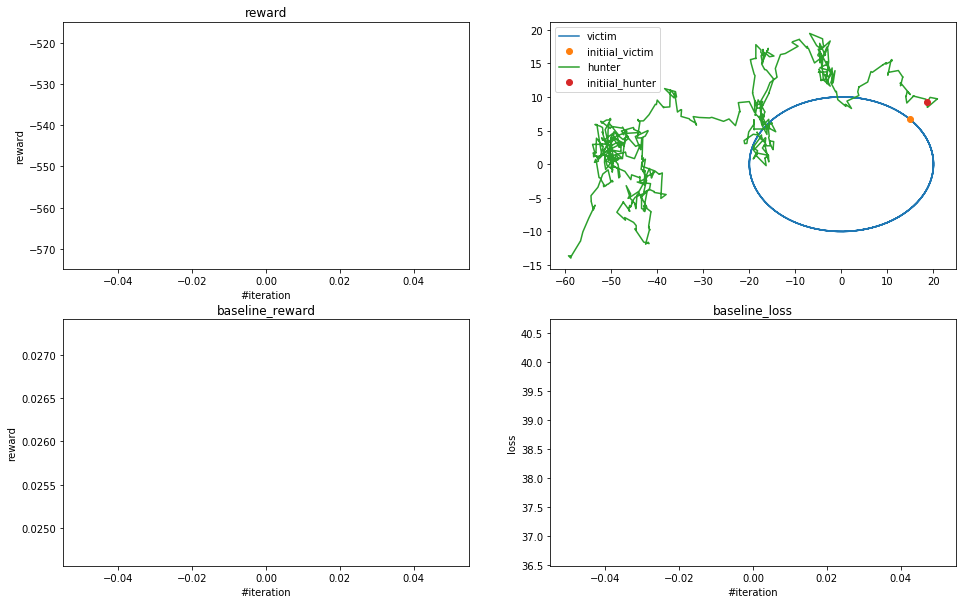

Episode 0 	Last reward: -545.00
Last reward: 0.03
values torch.Size([1000])
rewards torch.Size([1000])
baseline_rewards torch.Size([1000])
loss torch.Size([1000])
loss torch.Size([])
values torch.Size([1000])
rewards torch.Size([1000])
baseline_rewards torch.Size([1000])
loss torch.Size([1000])
loss torch.Size([])
values torch.Size([1000])
rewards torch.Size([1000])
baseline_rewards torch.Size([1000])
loss torch.Size([1000])
loss torch.Size([])


KeyboardInterrupt: 

In [14]:
train(policy,env, 1000,learning_rate=1e-4, baseline = baseline)

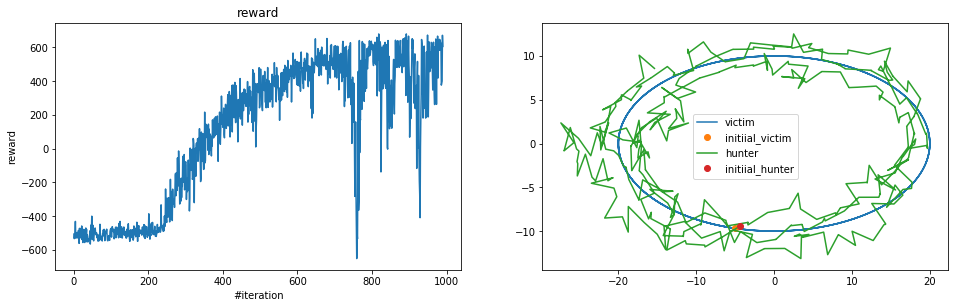

Episode 990 	Last reward: 605.00


In [2]:
train(policy,env, None, 1000, learning_rate=1e-4)

In [2]:
# torch.save(policy,'new_policy_speed_3.p')
# policy = torch.load(policy,'new_policy_speed_3.p')

### Test Visualization

In [3]:
from visualization import model_hunter_learning

<IPython.core.display.Javascript object>


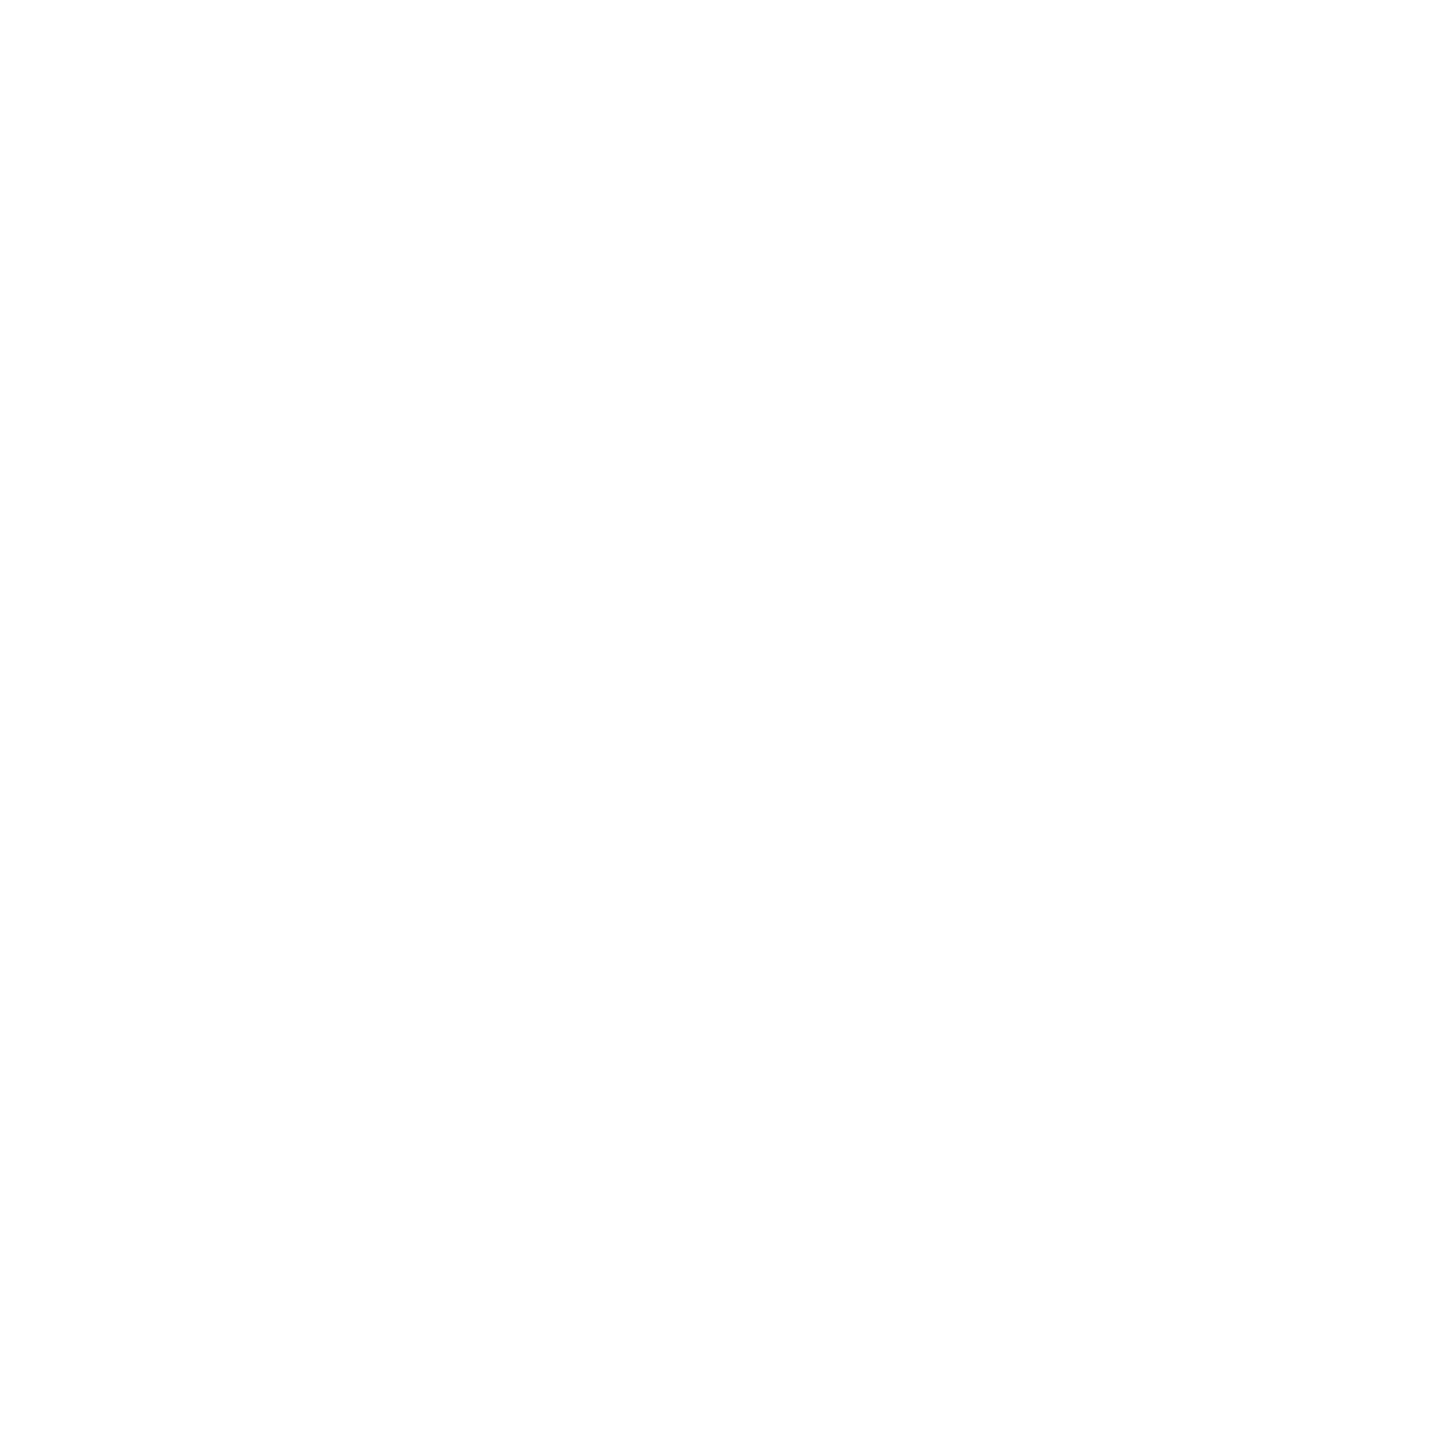

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


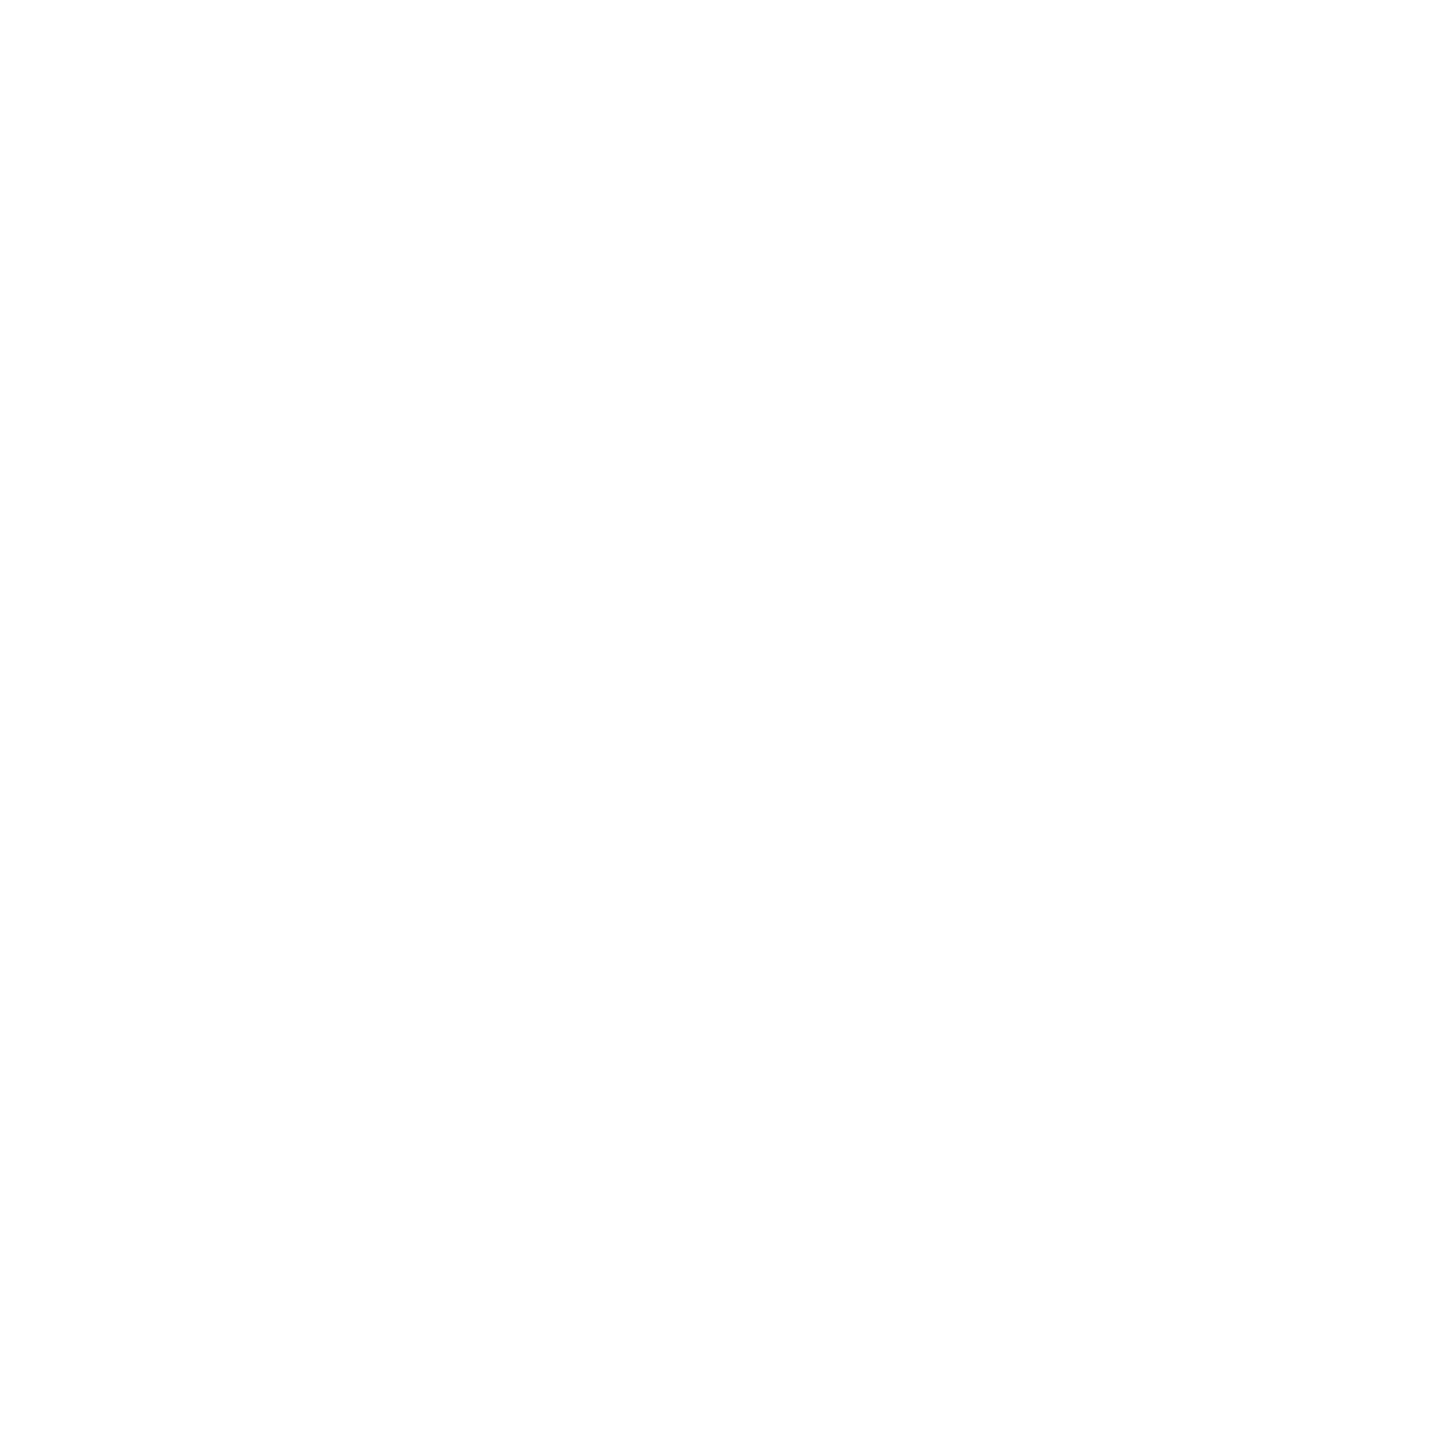

In [4]:
%matplotlib notebook
# policy = torch.load('acceleration_restricted_0.5_speed_3.p')
#env = VelocityHunterEnvironment(VictimPolicy.ellipse_victim_policy) #max_acceleration=0.5
model_hunter_learning('Test. max speed = 3',policy,env,hunter_start_position=[0,0])

<IPython.core.display.Javascript object>


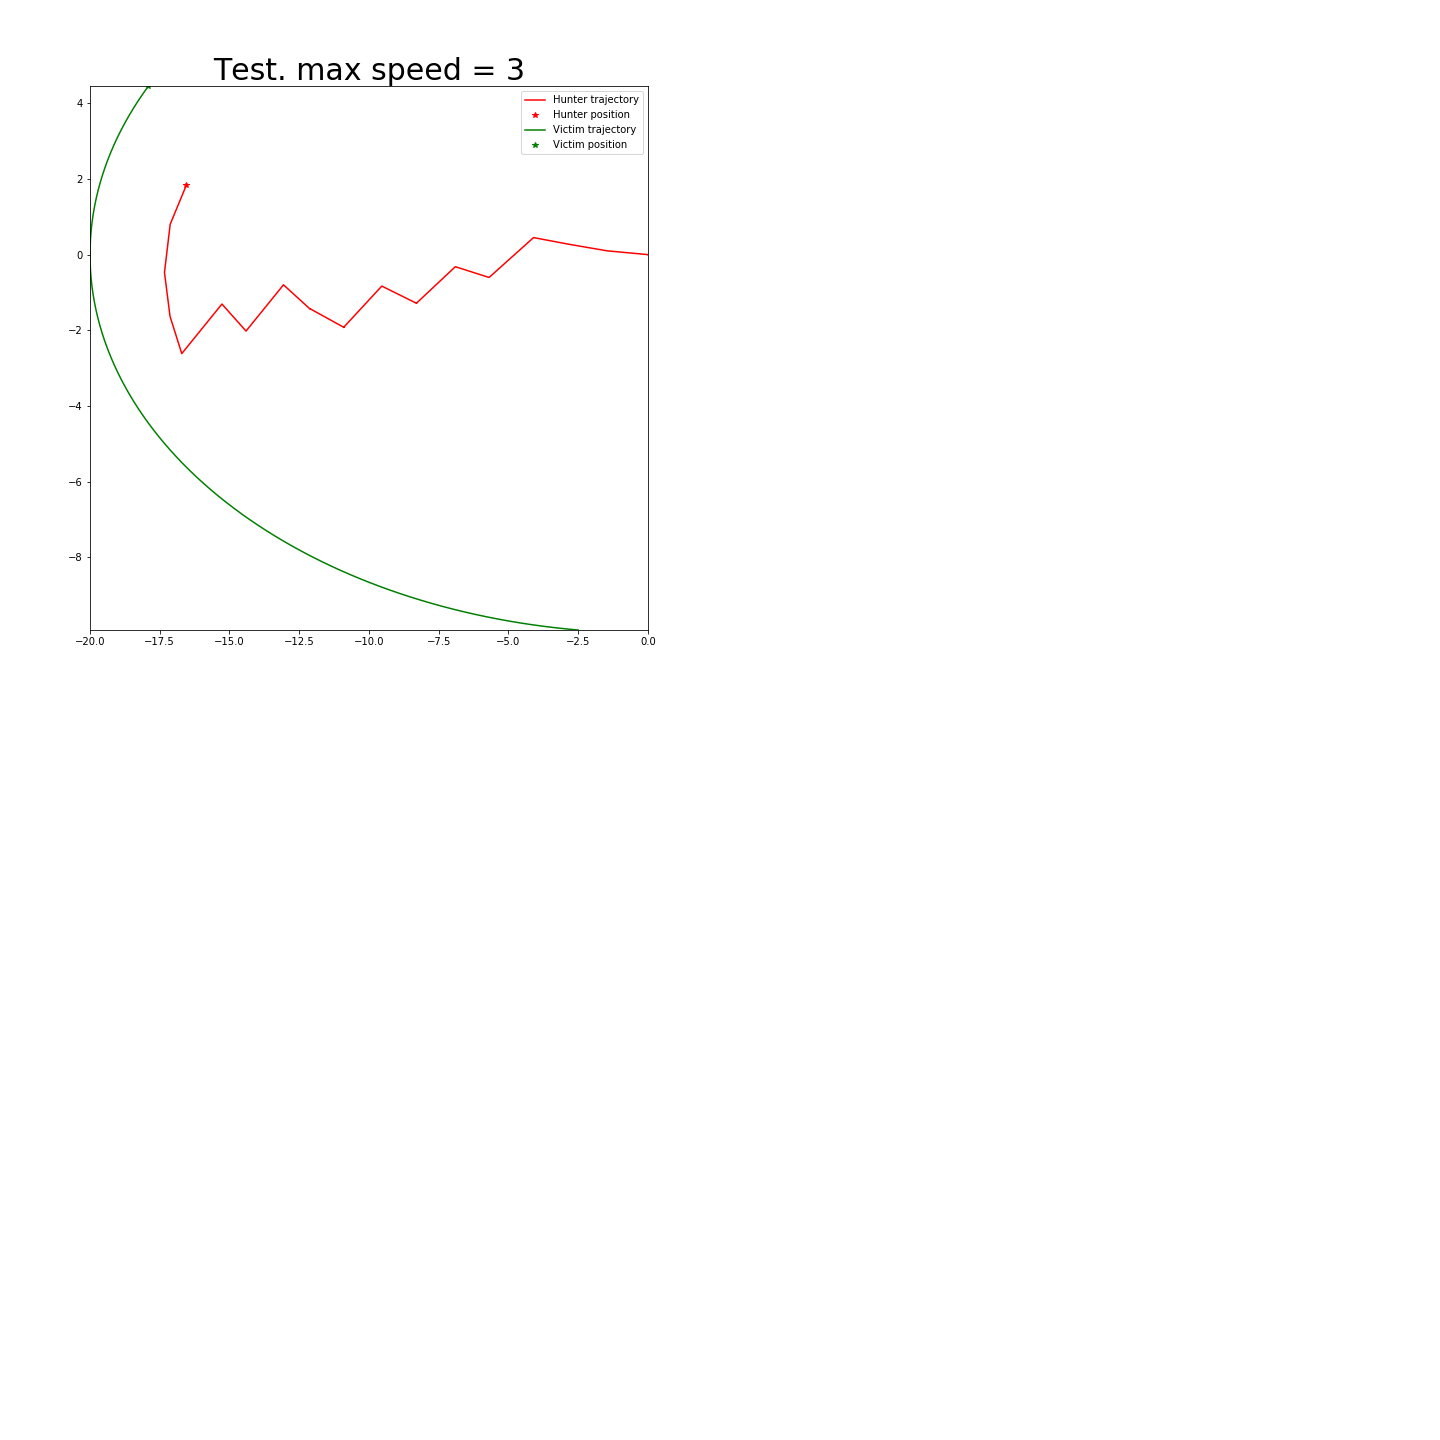

KeyboardInterrupt: 

In [6]:
# Ellipse

policy = torch.load('ellipse_policy_speed_3.p')
policy.max_action = 3
env = VelocityHunterEnvironment(VictimPolicy.ellipse_victim_policy)
model_hunter_learning('Test. max speed = 3',policy,env,hunter_start_position=[0,0])

<IPython.core.display.Javascript object>


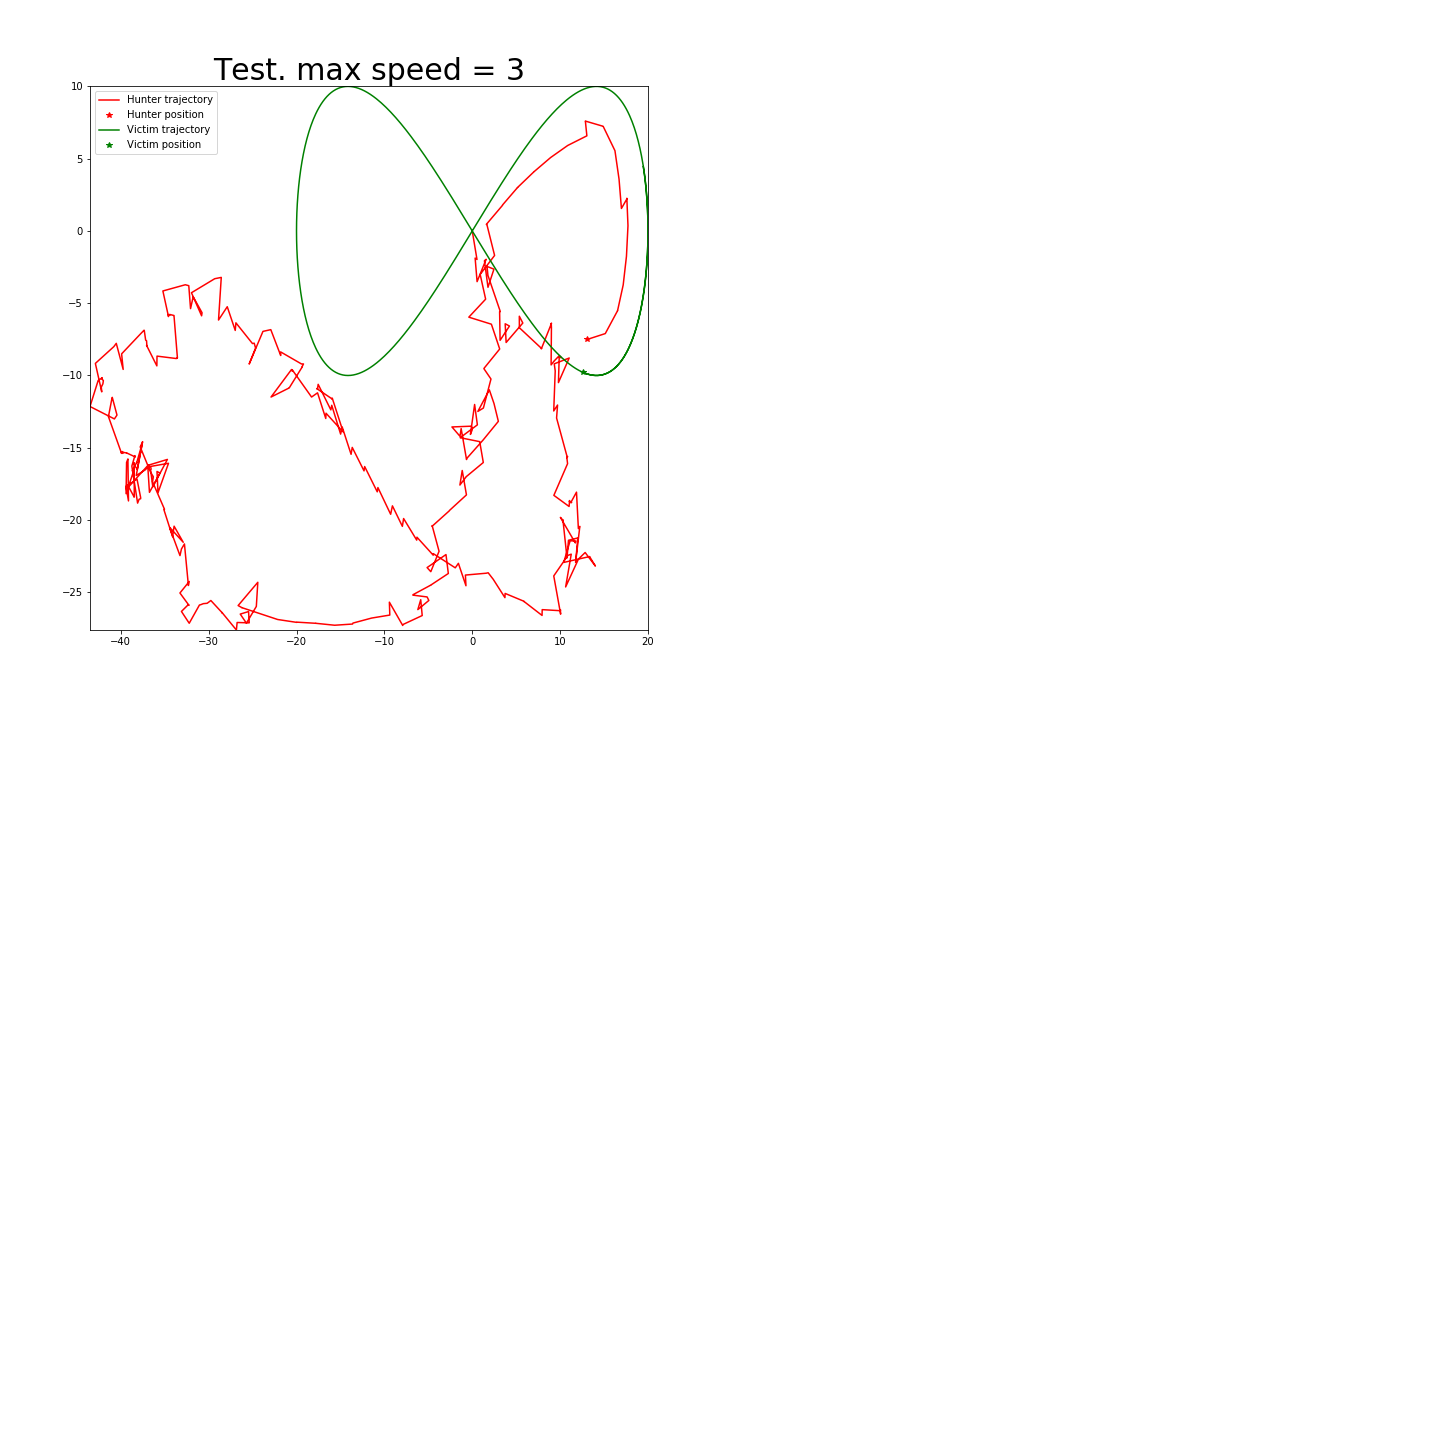

KeyboardInterrupt: 

In [9]:
# Eight

policy = torch.load('eight_policy_speed_3.p')
policy.max_action = 3
env = VelocityHunterEnvironment(VictimPolicy.eight_victim_policy)
model_hunter_learning('Test. max speed = 3',policy,env,hunter_start_position=[0,0])

<IPython.core.display.Javascript object>


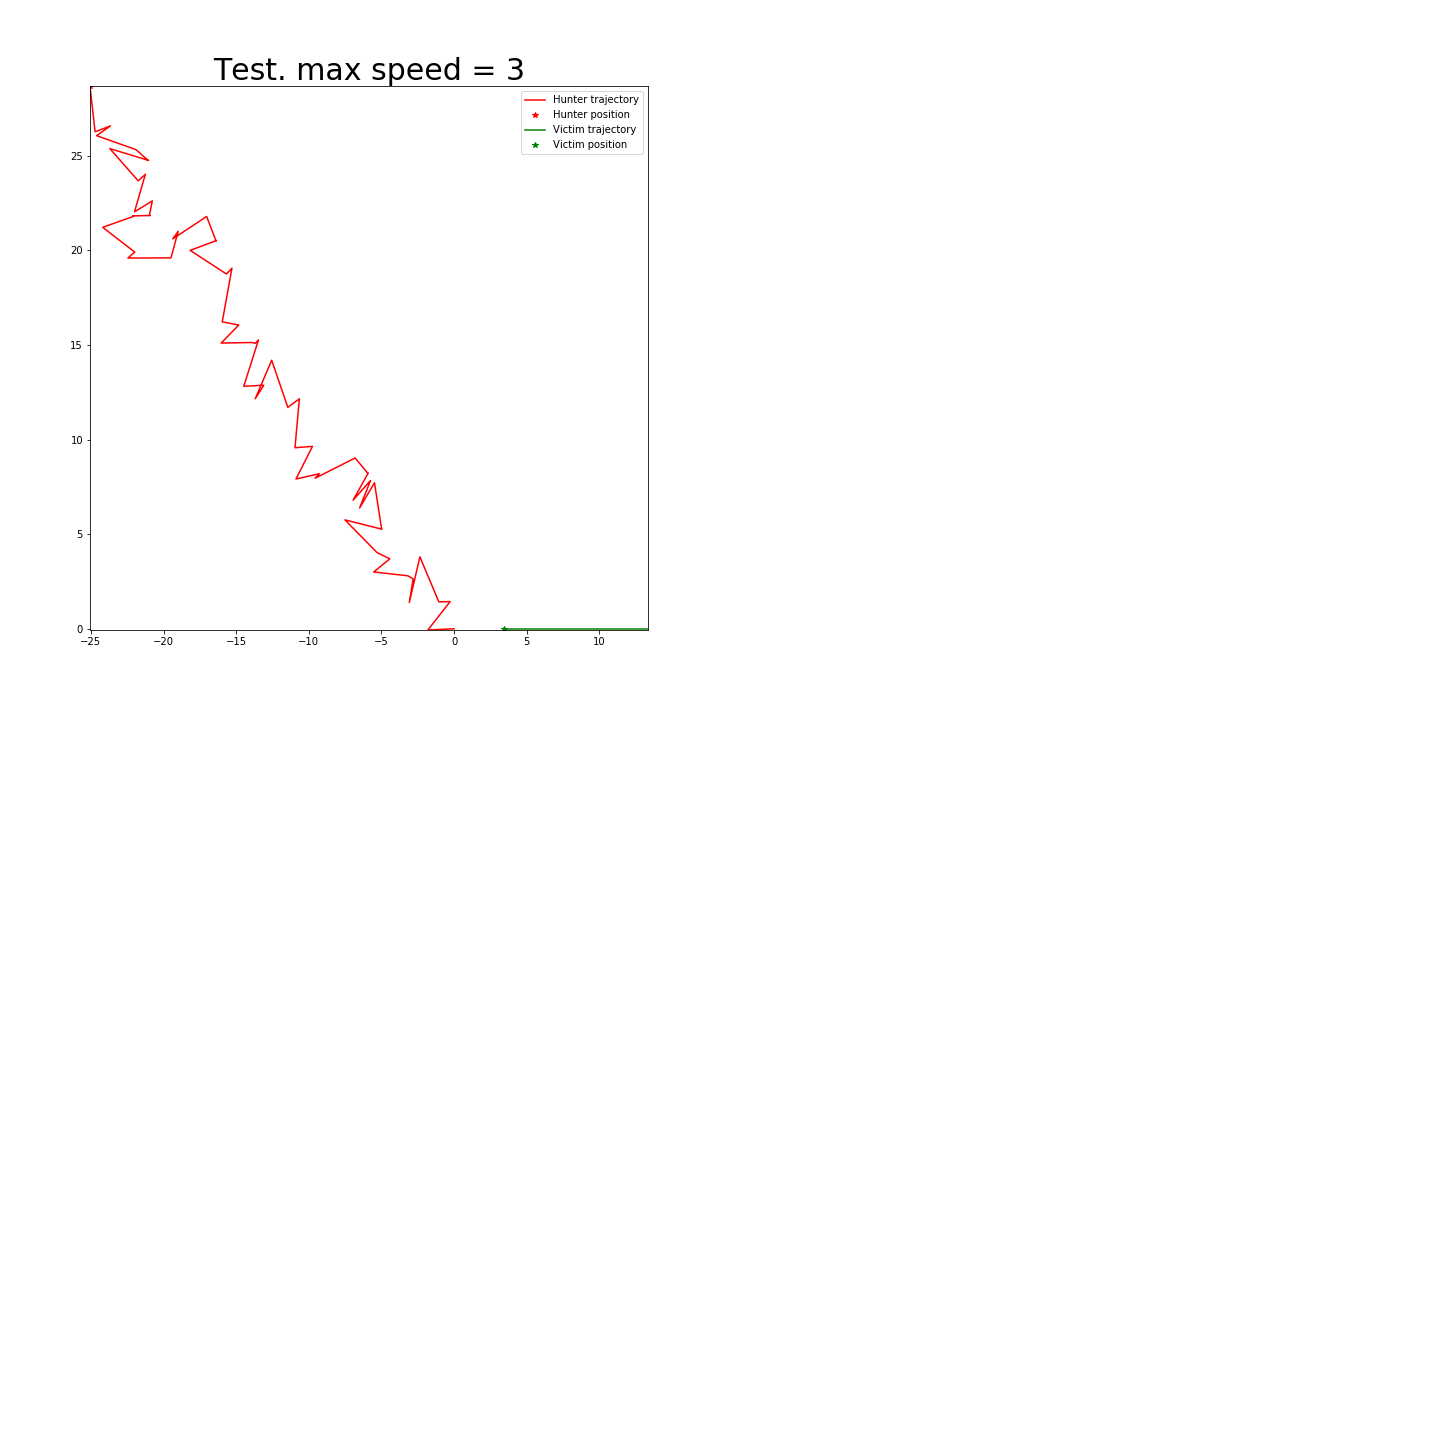

KeyboardInterrupt: 

In [15]:
# Triangular

policy = torch.load('triangle_policy_speed_3.p')
env = VelocityHunterEnvironment(VictimPolicy.triangle_victim_policy)
model_hunter_learning('Test. max speed = 3',policy,env,hunter_start_position=[0,0])

<IPython.core.display.Javascript object>


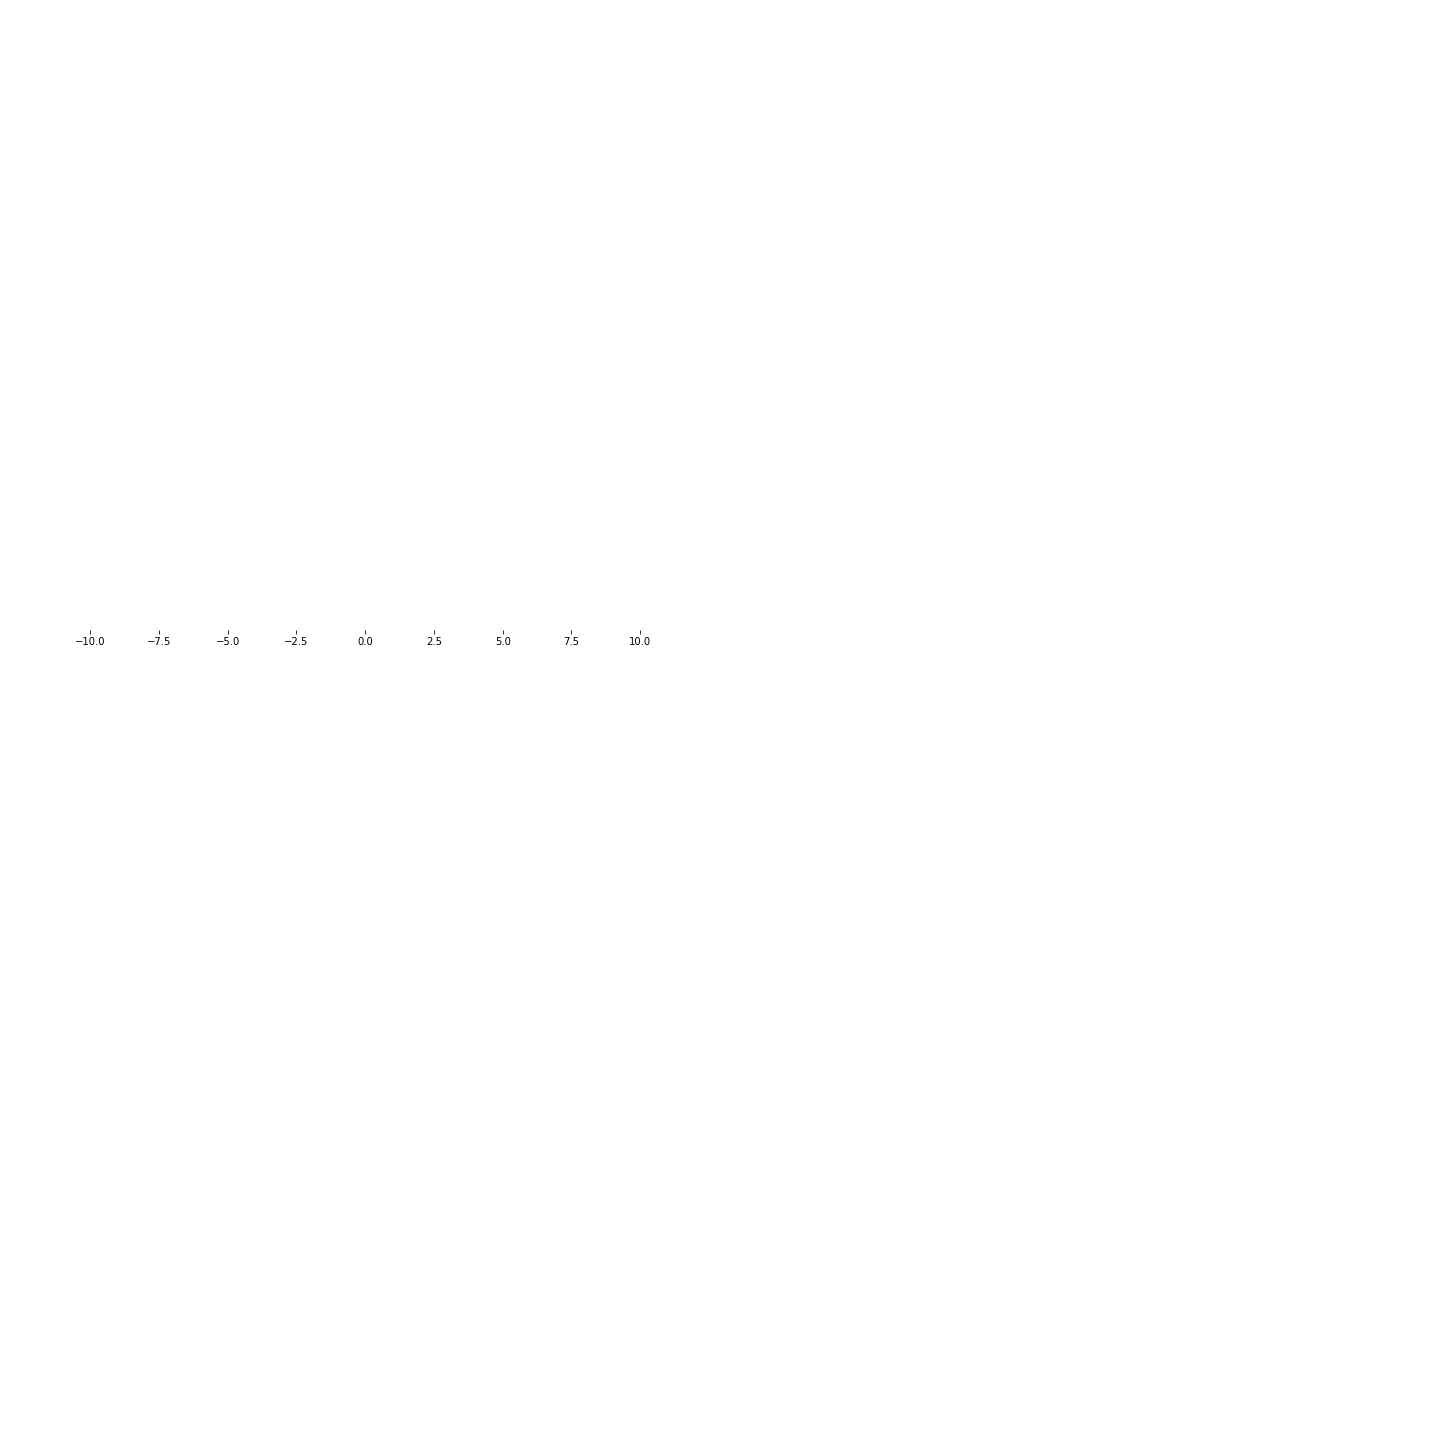

/Users/egornuzin/Yandex.Disk.localized/Files/Skoltech/Thesis/Hunter Learning/hunter_learning/environment.py:46: RuntimeWarning: invalid value encountered in double_scalars
  c = max((b-np.sqrt(D))/a,(b+np.sqrt(D))/a)
/Users/egornuzin/Yandex.Disk.localized/Files/Skoltech/Thesis/Hunter Learning/hunter_learning/environment.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  c = max((b-np.sqrt(D))/a,(b+np.sqrt(D))/a)
/Users/egornuzin/Yandex.Disk.localized/Files/Skoltech/Thesis/Hunter Learning/hunter_learning/environment.py:46: RuntimeWarning: invalid value encountered in sqrt
  c = max((b-np.sqrt(D))/a,(b+np.sqrt(D))/a)


KeyboardInterrupt: 

In [19]:
# Acceleration restricted

policy = torch.load('acceleration_restricted_0.5_speed_3.p')
env = VelocityHunterEnvironment(VictimPolicy.circle_victim_policy, max_acceleration=0.5)
model_hunter_learning('Test. max speed = 3',policy,env,hunter_start_position=[0,0])